In [7]:
from __future__ import division
from __future__ import print_function

import sys
sys.path.append("../")

import neurofit as nf

from neurofit.utils import normalize

import time
import utils
import pyspike as spk

import cneurons as cn
from scipy.signal import decimate, resample


#plotting packages
%matplotlib inline
from matplotlib.pyplot import * # plotting functions
import seaborn as sns           # data visualization package
import pandas as pd             # data analysis and manipulation package
from corner import corner 

sns.set_style('whitegrid')
clr = sns.color_palette('cubehelix',5)
sns.set_palette(sns.color_palette(clr))
rcParams['figure.figsize'] = (16,10) 

In [15]:
# load data from crcns
cell = "yg0616_4_B"
stim_type = "conspecific"

# dstrf settings
nwalkers = 1000
burn = 10
dstrf_burn = 1000
threads = 8
keep = 1
num_assim_stims = 15
free_ts = True

nspec = 30
t_dsample = 5
tlen = int(np.rint(150/t_dsample))
psth_smooth = 5/t_dsample

compress = 1

channels = 3
scale = 1

# load data from crcns
stims,durations,spikes_data,spiky_data = utils.load_crcns(cell,stim_type,nspec,t_dsample,compress)

psth_data = [utils.psth_spiky(spiky,binres=1,smooth=psth_smooth,dsample=t_dsample) for spiky in spiky_data]

In [6]:
# set priors
from neurofit import priors

mat_priors   =  [ priors.uniform(-1000,  1000),
                  priors.uniform( -100,   100),
                  priors.uniform( -100,   100),
                  priors.uniform( -1000,  1000)]
tau_priors   =  [ priors.uniform(    1,   500),
                  priors.uniform(    1,   500)]

tlen_prior   =  [ priors.uniform(    1,   150)]
param_priors =  [ priors.uniform( -100,   100),
                  priors.uniform( -100,   100),
                  priors.uniform( -100,   100),
                  priors.uniform( -100,   100),
                  priors.uniform(    0,    50),
                  priors.uniform(    0, nspec),
                  priors.uniform(    0, nspec)]

if free_ts: mat_priors.extend(tau_priors)

dstrf_prior = priors.joint_independent(mat_priors + tlen_prior + param_priors*channels)

In [8]:
from neurofit import examples
param_fit = examples.fit_parameterized_strf(norm_psth_data[:num_assim_stims],stims[:num_assim_stims],
                                               channels=channels,nonlin=nonlin,
                                               param_priors=tlen_prior+param_priors*channels,
                                               burn=burn,progress_bar=True,
                                               threads=threads)

 [##########] 10 samples in 00:1110 about 00:00 remaining

In [9]:
pml = param_fit.flatchain[np.argmax(param_fit.flatlnprobability)]
param_maxlik = nf.models.parameterized_strf(channels,nspec)
param_maxlik.set(pml)
param_corr = utils.evaluate(param_maxlik.filt,stims[num_assim_stims:],psth_data[num_assim_stims:])

I_param = []
for i,x in enumerate(stims):
    I_param.append(resample(param_maxlik.run(x),durations[i])*scale)
print(param_corr)

-0.12117584823


In [10]:
I = I_param
mat_fit = nf.examples.fit_mat(spiky_data[:num_assim_stims],I[:num_assim_stims],
                              burn=burn,progress_bar=True,threads=threads,
                              mat_priors=mat_priors,
                              free_ts=free_ts)

 [##########] 10 samples in 00:1009 about 00:00 remaining

In [11]:
reload(utils)
mml = mat_fit.flatchain[np.argmax(mat_fit.flatlnprobability)]
mat_maxlik = nf.models.mat()
mat_maxlik.set(mml)
mat_corr = []
for i,x in enumerate(I):
    if i < num_assim_stims:
        trace,spikes = mat_maxlik.run(x)
        mspky = spk.SpikeTrain(spikes,[0,durations[i]])
        mat_psth = utils.psth_spiky(mspky,binres=1,smooth=psth_smooth,dsample=t_dsample)
        mat_corr.append(np.corrcoef(psth_data[i],mat_psth)[0][1])
        param_psth = param_maxlik.run(stims[i])
        param_psth[param_psth < 0] = 0
print("Filt R: {:.3f}, MAT R: {:.3f}".format(param_corr,np.mean(mat_corr)))

mml = [10,0.1,0.1,10,10,200]

Filt R: -0.121, MAT R: 0.482


In [51]:
# define dstrf class
class dstrf():
    def __init__(self,channels=1,nspec=15,upsample=1,scale=1,free_ts=False,nonlin=False):
        self.mat = nf.models.mat(free_ts=free_ts)
        self.pstrf = nf.models.parameterized_strf(channels,nspec,nonlin=nonlin)
        self.upsample = upsample
        self.scale = scale
        self.free_ts = free_ts
        self.channels = channels
        
    def dim(self):
        return self.channels*(7) + 7 if self.free_ts else 5
    
    def set(self, theta):
        cut = 6 if self.free_ts else 4
        self.mat.set(theta[:cut])
        self.pstrf.set(theta[cut:])
        
    def run(self, stim):
        r = self.pstrf.run(stim)
        r = resample(nf.utils.normalize(r),len(r)*self.upsample)*self.scale
        return self.mat.run(r)
    
def spiky_hinge(predict,data):
    trace, spikes = predict
    spiky = spk.SpikeTrain(spikes,[0,data[0].t_end])
    sync = np.mean([spk.spike_sync(spiky,trial) for trial in data])
    return 1000*max(0,1-(2*sync-1))


In [19]:
model = dstrf(channels=channels,nspec=nspec,upsample=t_dsample,scale=scale,free_ts=free_ts)
smplr = nf.sampler(model, dstrf_prior, spiky_hinge, nwalkers, zip(stims,spiky_data), 8)

In [20]:
import progressbar as pb
bar = pb.ProgressBar(max_value=burn, widgets= [" [", pb.Timer(), "] ", pb.Bar(), " (", pb.ETA(), ") "])

start = np.hstack((mml,pml))

p0 = nf.startpos.gaussian(start,[0.1]*len(start),nwalkers)

a = 0
for x in bar(smplr.sample(p0, iterations=burn)): continue

 [Elapsed Time: 0:00:30] |#########################################################################| (Time: 0:00:30) 


In [24]:
out = smplr

0.696933427678


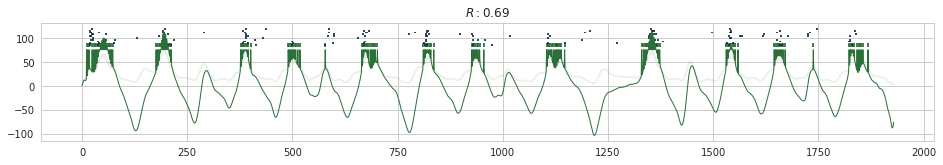

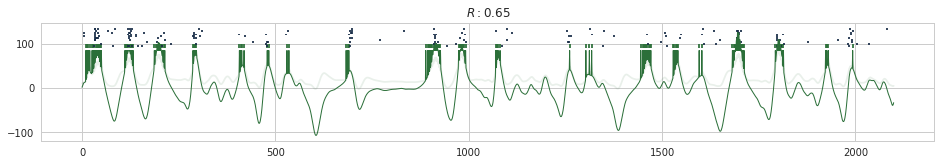

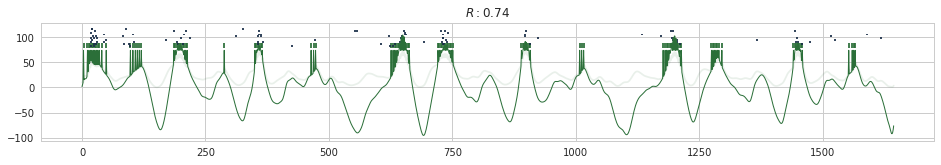

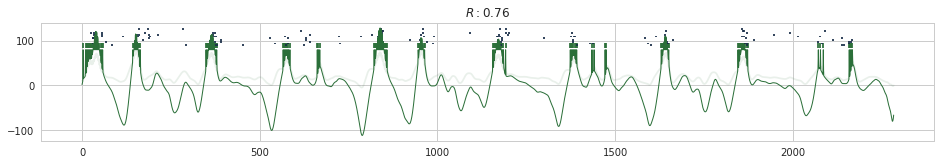

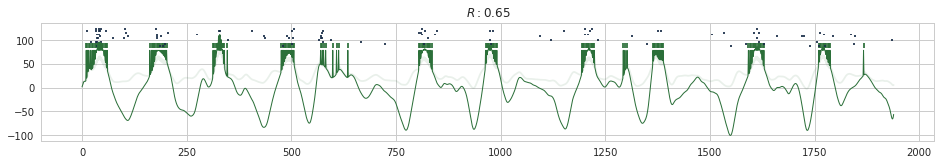

In [25]:
maxlik = out.flatchain[out.flatlnprobability.argmax()]
maxlik_nrn = dstrf(channels=channels,nspec=nspec,upsample=t_dsample,scale=scale,free_ts=free_ts) 
maxlik_nrn.set(maxlik)

sscale = 0.05

all_corr = []
for j,i in enumerate(stims):
    if j >= num_assim_stims:
        trace, spikes = maxlik_nrn.run(i) 
        V, thresh = trace.T
        height = max(thresh)
        spad = height/10
        V[spikes] = height
        figure()
        spky = spk.SpikeTrain(spikes,[0,spiky_data[j][0].t_end])
        corr = np.corrcoef(utils.psth_spiky(spky,binres=1,smooth=psth_smooth,dsample=t_dsample),psth_data[j])[0][1]
        all_corr.append(corr)
        subplot(411)
        title("$R: {:.2f}$".format(corr))
        plot(thresh,alpha=0.1,color=clr[1])
        plot(V,linewidth=1,color=clr[1])
        vlines(spikes,height+5,height+15,color=clr[1])
        for i,trial in enumerate(spiky_data[j]):
            vlines(trial.spikes,spad+height+sscale*height*i,spad+height+sscale*height*(i+1),alpha=1,color=clr[0])
print(np.mean(all_corr))

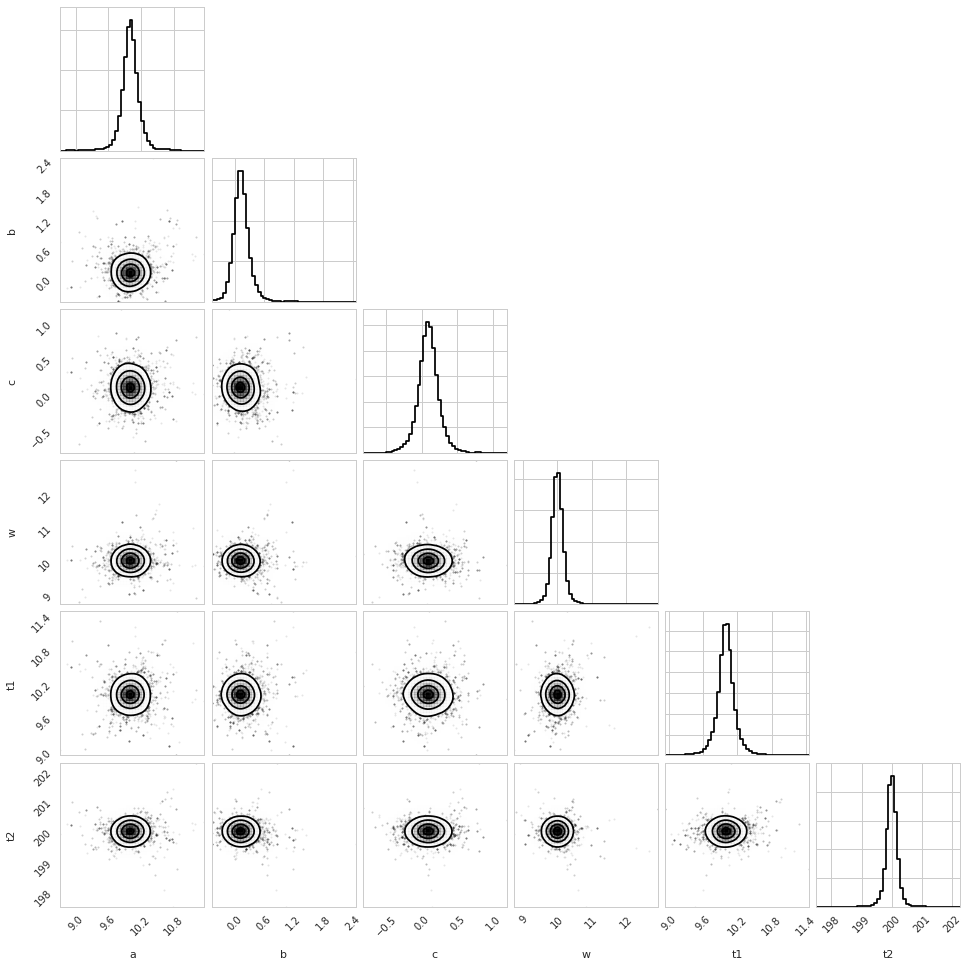

In [26]:
cut = 6 if free_ts else 4
matlabs = ['a','b','c','w','t1','t2']
corner(out.flatchain[:,:cut],bins=50,smooth=2,smooth1d=1,labels=matlabs[:cut]);

In [46]:
reload(graphics)
from neurofit import graphics

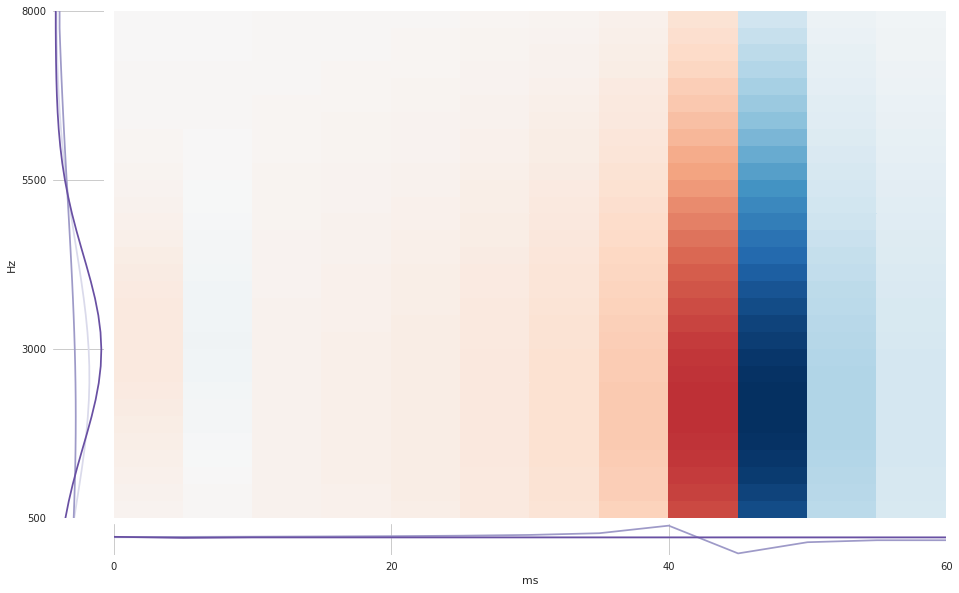

In [47]:
graphics.strf_plot(maxlik_nrn.pstrf.sfilt,maxlik_nrn.pstrf.tfilt,500,8000,5)

In [48]:
def trialcorr(spiky_data,bin_length=1,smooth=1,dsample=10):
    spiky_data = np.asarray(spiky_data)
    A = []
    trialn = range(len(spiky_data))
    for i, trial in enumerate(spiky_data):
        ixclude = [n for n in trialn if n != i]
        ipsth = utils.psth([trial],bin_length,smooth=smooth,dsample=dsample)
        compare = utils.psth(spiky_data[ixclude],bin_length,smooth=smooth,dsample=dsample)
        A.append(np.corrcoef(ipsth,compare)[0][1])
    return np.nanmean(A)

def evenoddcorr(spiky_data,bin_length=1,smooth=1,dsample=10):
    spiky_data = np.asarray(spiky_data)
    trialns = np.arange(len(spiky_data))
    evens = np.where(trialns % 2 == 0)[0]
    odds = np.where(trialns % 2 != 0)[0]

    evens = utils.psth_spiky(spiky_data[evens],bin_length,smooth=smooth,dsample=dsample)
    odds = utils.psth_spiky(spiky_data[odds],bin_length,smooth=smooth,dsample=dsample)
    return np.corrcoef(evens,odds)[0][1]
    
eocorr = [evenoddcorr(spky,dsample=t_dsample,smooth=psth_smooth,bin_length=1) for spky in spiky_data]

In [49]:
n_smpl_trials = 100
assim_used = range(num_assim_stims)

idx = [None]
smpl_idx = None
MANY = []
traces = []

for i in range(n_smpl_trials):
    while smpl_idx in idx:
        smpl_idx = np.random.randint(len(out.flatchain))
    idx.append(smpl_idx)
    maxlik2 = out.flatchain[smpl_idx]
    maxlik_nrn2 = dstrf(channels=channels,nspec=nspec,upsample=t_dsample,scale=scale,free_ts=free_ts) 
    maxlik_nrn2.set(maxlik2)
    
    resp_spiky = []
    for i, stim in enumerate(stims):
        trace, spikes = maxlik_nrn2.run(stim) 
        V, thresh = trace.T
        spky = spk.SpikeTrain(spikes,[0,spiky_data[i][0].t_end])
        resp_spiky.append(spky)
        traces.append(thresh)
    MANY.append(resp_spiky)

corr2 = []
for i in range(len(stims)):
    if i not in assim_used:
        WOO = utils.psth_spiky(np.asarray(MANY)[:,i],1,t_dsample,psth_smooth)
        thiscorr = np.corrcoef(WOO,psth_data[i])[0][1]
        corr2.append(thiscorr)

In [50]:
corr_means = np.mean([all_corr,corr2,eocorr[num_assim_stims:]],axis=1)
print("MAP: {:.2f}, Dist: {:.2f}, EO: {:.2f}".format(corr_means[0],corr_means[1],corr_means[2]))
print("MAP/EO: {:.2f}, Dist/EO: {:.2f}".format(corr_means[0]/corr_means[2],corr_means[1]/corr_means[2]))

MAP: 0.70, Dist: 0.38, EO: 0.71
MAP/EO: 0.98, Dist/EO: 0.54
